[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv10 Object Detection on a Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2405.14458-b31b1b.svg)](https://arxiv.org/pdf/2405.14458.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/THU-MIG/yolov10)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/YOLO-ARENA)

YOLOv10 is a new generation in the YOLO series for real-time end-to-end object detection. It aims to improve both the performance and efficiency of YOLOs by eliminating the need for non-maximum suppression (NMS) and optimizing model architecture comprehensively. This advancement reduces computational overhead, enhancing both efficiency and capability. YOLOv10 shows state-of-the-art performance and efficiency, with YOLOv10-S being 1.8 times faster than RT-DETR-R18 and having significantly fewer parameters and FLOPs. Additionally, YOLOv10-B demonstrates 46% less latency and 25% fewer parameters compared to YOLOv9-C while maintaining the same performance.

<p align="center">
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_latency.svg" width=48%>
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_params.svg" width=48%> <br>
  Comparisons with others in terms of latency-accuracy (left) and size-accuracy (right) trade-offs.
</p>

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv10
- Download pre-trained weights
- Download example data
- Inference with Pre-trained COCO Model
- Download dataset from Roboflow Universe
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Sep 20 16:02:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


## Install YOLOv10

**NOTE:** Currently, YOLOv10 does not have its own PyPI package. Therefore, we need to install the code from the source.

In [4]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

**NOTE:** We will also install two additional packages: [`roboflow`](https://github.com/roboflow/roboflow-python) to download the dataset from [Roboflow Universe](https://universe.roboflow.com/), which we will use to train our model, and [`supervision`](https://github.com/roboflow/supervision), which we will use for visualizing the results.

In [26]:
# !pip install -q supervision
!pip install --upgrade supervision

In [23]:
!pip install -q roboflow

**NOTE:** Uninstall `wandb`: unwanted account creation prompt with infinite hang during training.

In [24]:
!pip uninstall -y wandb

## Download pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [8]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26  2024 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26  2024 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26  2024 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26  2024 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26  2024 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26  2024 yolov10x.pt


## Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [9]:
!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh {HOME}/data

total 104K
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg


## Inference with Pre-trained COCO Model

**NOTE:** YOLOv10 is based on YOLOv8, and like YOLOv8, it can be used in both CLI and SDK modes.

### 💻 CLI

In [13]:
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 12.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.22.2
    Uninstalling huggingface-hub-0.22.2:
      Successfully uninstalled huggingface-hub-0.22.2


In [14]:
!pip show ultralytics huggingface_hub

Name: ultralytics
Version: 8.1.34
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: 
Author: Glenn Jocher, Ayush Chaurasia, Jing Qiu
Author-email: 
License: AGPL-3.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: matplotlib, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 
---
Name: huggingface-hub
Version: 0.35.0
Summary: Client library to download and publish models, datasets and other repos on the huggingface.co hub
Home-page: https://github.com/huggingface/huggingface_hub
Author: Hugging Face, Inc.
Author-email: julien@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.10/site-packages
Requires: filelock, fsspec, hf-xet, packaging, pyyaml, requests, tqdm, typing-extensions
Required-by: accelerate, datasets, timm, tokenizers, transformers


In [15]:
%cd {HOME}

!yolo task=detect mode=predict conf=0.25 save=True \
model={HOME}/weights/yolov10n.pt \
source={HOME}/data/dog.jpeg

/kaggle/working
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2762608 parameters, 63840 gradients, 8.6 GFLOPs

image 1/1 /kaggle/working/data/dog.jpeg: 640x384 1 person, 1 dog, 79.5ms
Speed: 4.7ms preprocess, 79.5ms inference, 200.1ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NONE:** Let's display result.

/kaggle/working


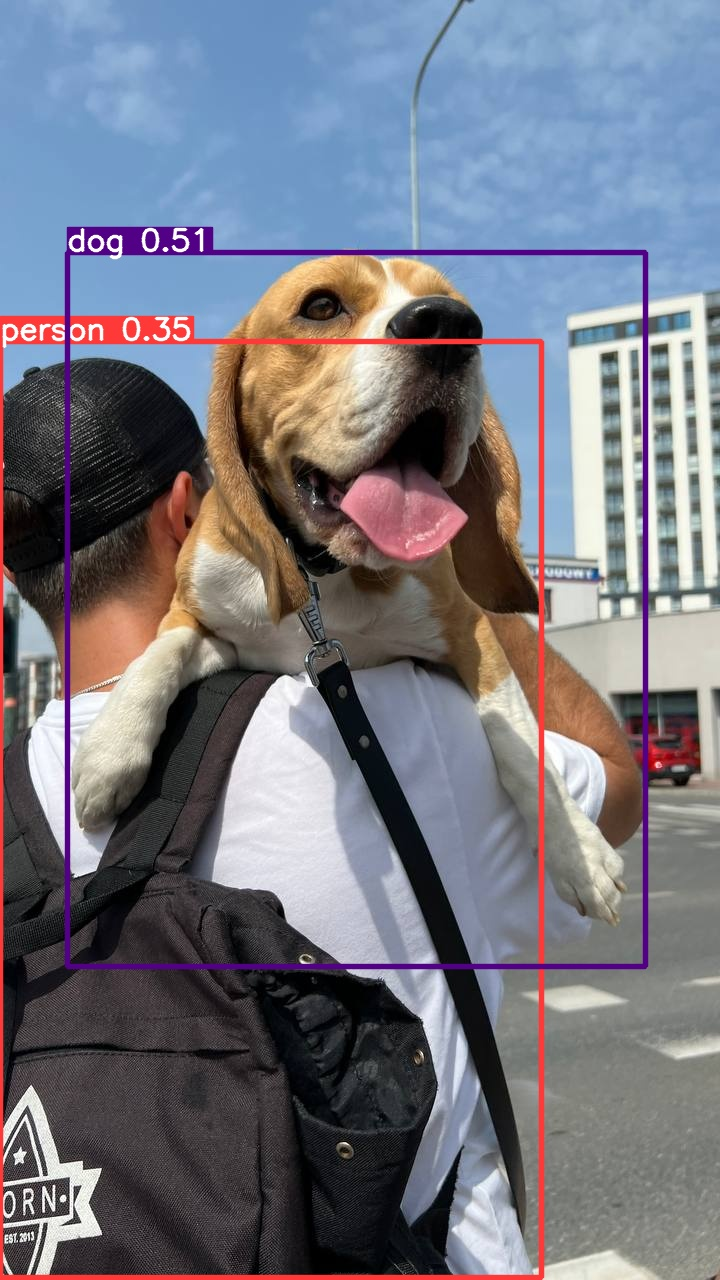

In [16]:
%cd {HOME}

from IPython.display import Image

Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

In [17]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
results = model(source=f'{HOME}/data/dog.jpeg', conf=0.25)


image 1/1 /kaggle/working/data/dog.jpeg: 640x384 1 person, 1 dog, 73.1ms
Speed: 4.0ms preprocess, 73.1ms inference, 129.5ms postprocess per image at shape (1, 3, 640, 384)


In [18]:
results[0].boxes.xyxy

tensor([[6.7041e+01, 2.5264e+02, 6.4549e+02, 9.6621e+02],
        [7.4646e-01, 3.4156e+02, 5.4170e+02, 1.2773e+03]], device='cuda:0')

In [19]:
results[0].boxes.conf

tensor([0.5090, 0.3536], device='cuda:0')

In [20]:
results[0].boxes.cls

tensor([16.,  0.], device='cuda:0')

**NONE:** Let's display result using `supervision`.

In [67]:
# import cv2
# import supervision as sv
# from ultralytics import YOLOv10

# model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
# image = cv2.imread(f'{HOME}/data/dog.jpeg')
# results = model(image)[0]
# detections = sv.Detections.from_ultralytics(results)

# bounding_box_annotator = sv.BoundingBoxAnnotator()
# label_annotator = sv.LabelAnnotator()

# annotated_image = bounding_box_annotator.annotate(
#     scene=image, detections=detections)
# annotated_image = label_annotator.annotate(
#     scene=annotated_image, detections=detections)

# sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [28]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow

rf = Roboflow(api_key="n12mRmQdWmrjCSKFgJMC")
project = rf.workspace("waste-detections-by-fu").project("waste-detections-c0mkz")
version = project.version(6)
dataset = version.download("yolov8")



# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
# ROBOFLOW_API_KEY = user_secrets.get_secret("ROBOFLOW_API_KEY")

# rf = Roboflow(api_key=ROBOFLOW_API_KEY)
# project = rf.workspace("selencakmak").project("tumor-dj2a1")
# version = project.version(1)
# dataset = version.download("yolov8")


/kaggle/working/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Waste-Detections-6 in yolov8:: 100%|██████████| 14224/14224 [00:02<00:00, 5844.80it/s]


**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow Universe, run the command below. 👇🏻

In [29]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [30]:
!cat {dataset.location}/data.yaml

names:
- Paper
- Plastic Bottle
- Plastic bag
- Plastic waste
nc: 4
roboflow:
  license: CC BY 4.0
  project: waste-detections-c0mkz
  url: https://universe.roboflow.com/waste-detections-by-fu/waste-detections-c0mkz/dataset/6
  version: 6
test: ../test/images
train: ../train/images
val: ../valid/images


In [31]:
dataset.location

'/kaggle/working/datasets/Waste-Detections-6'

In [43]:
!du -sh {dataset.location}/train/images  # Original
!du -sh /kaggle/working/compressed_images  # Compressed

556M	/kaggle/working/datasets/Waste-Detections-6/train/images
4.0K	/kaggle/working/compressed_images


In [38]:
# !pip install --upgrade pillow

## Custom Training

In [44]:
%cd {HOME}

!yolo task=detect mode=train epochs=50 batch=32 plots=True device=0,1 \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml

/kaggle/working
New https://pypi.org/project/ultralytics/8.3.202 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/datasets/Waste-Detections-6/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=(0, 1), workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, sour

In [45]:
print(model.train.__defaults__)  # View default training parameters

(None,)


In [52]:
from PIL import Image


In [46]:
!ls {HOME}/runs/detect/train/

F1_curve.png					   train_batch1.jpg
PR_curve.png					   train_batch2.jpg
P_curve.png					   train_batch8000.jpg
R_curve.png					   train_batch8001.jpg
args.yaml					   train_batch8002.jpg
confusion_matrix.png				   val_batch0_labels.jpg
confusion_matrix_normalized.png			   val_batch0_pred.jpg
events.out.tfevents.1758386530.af9808613227.301.0  val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


/kaggle/working


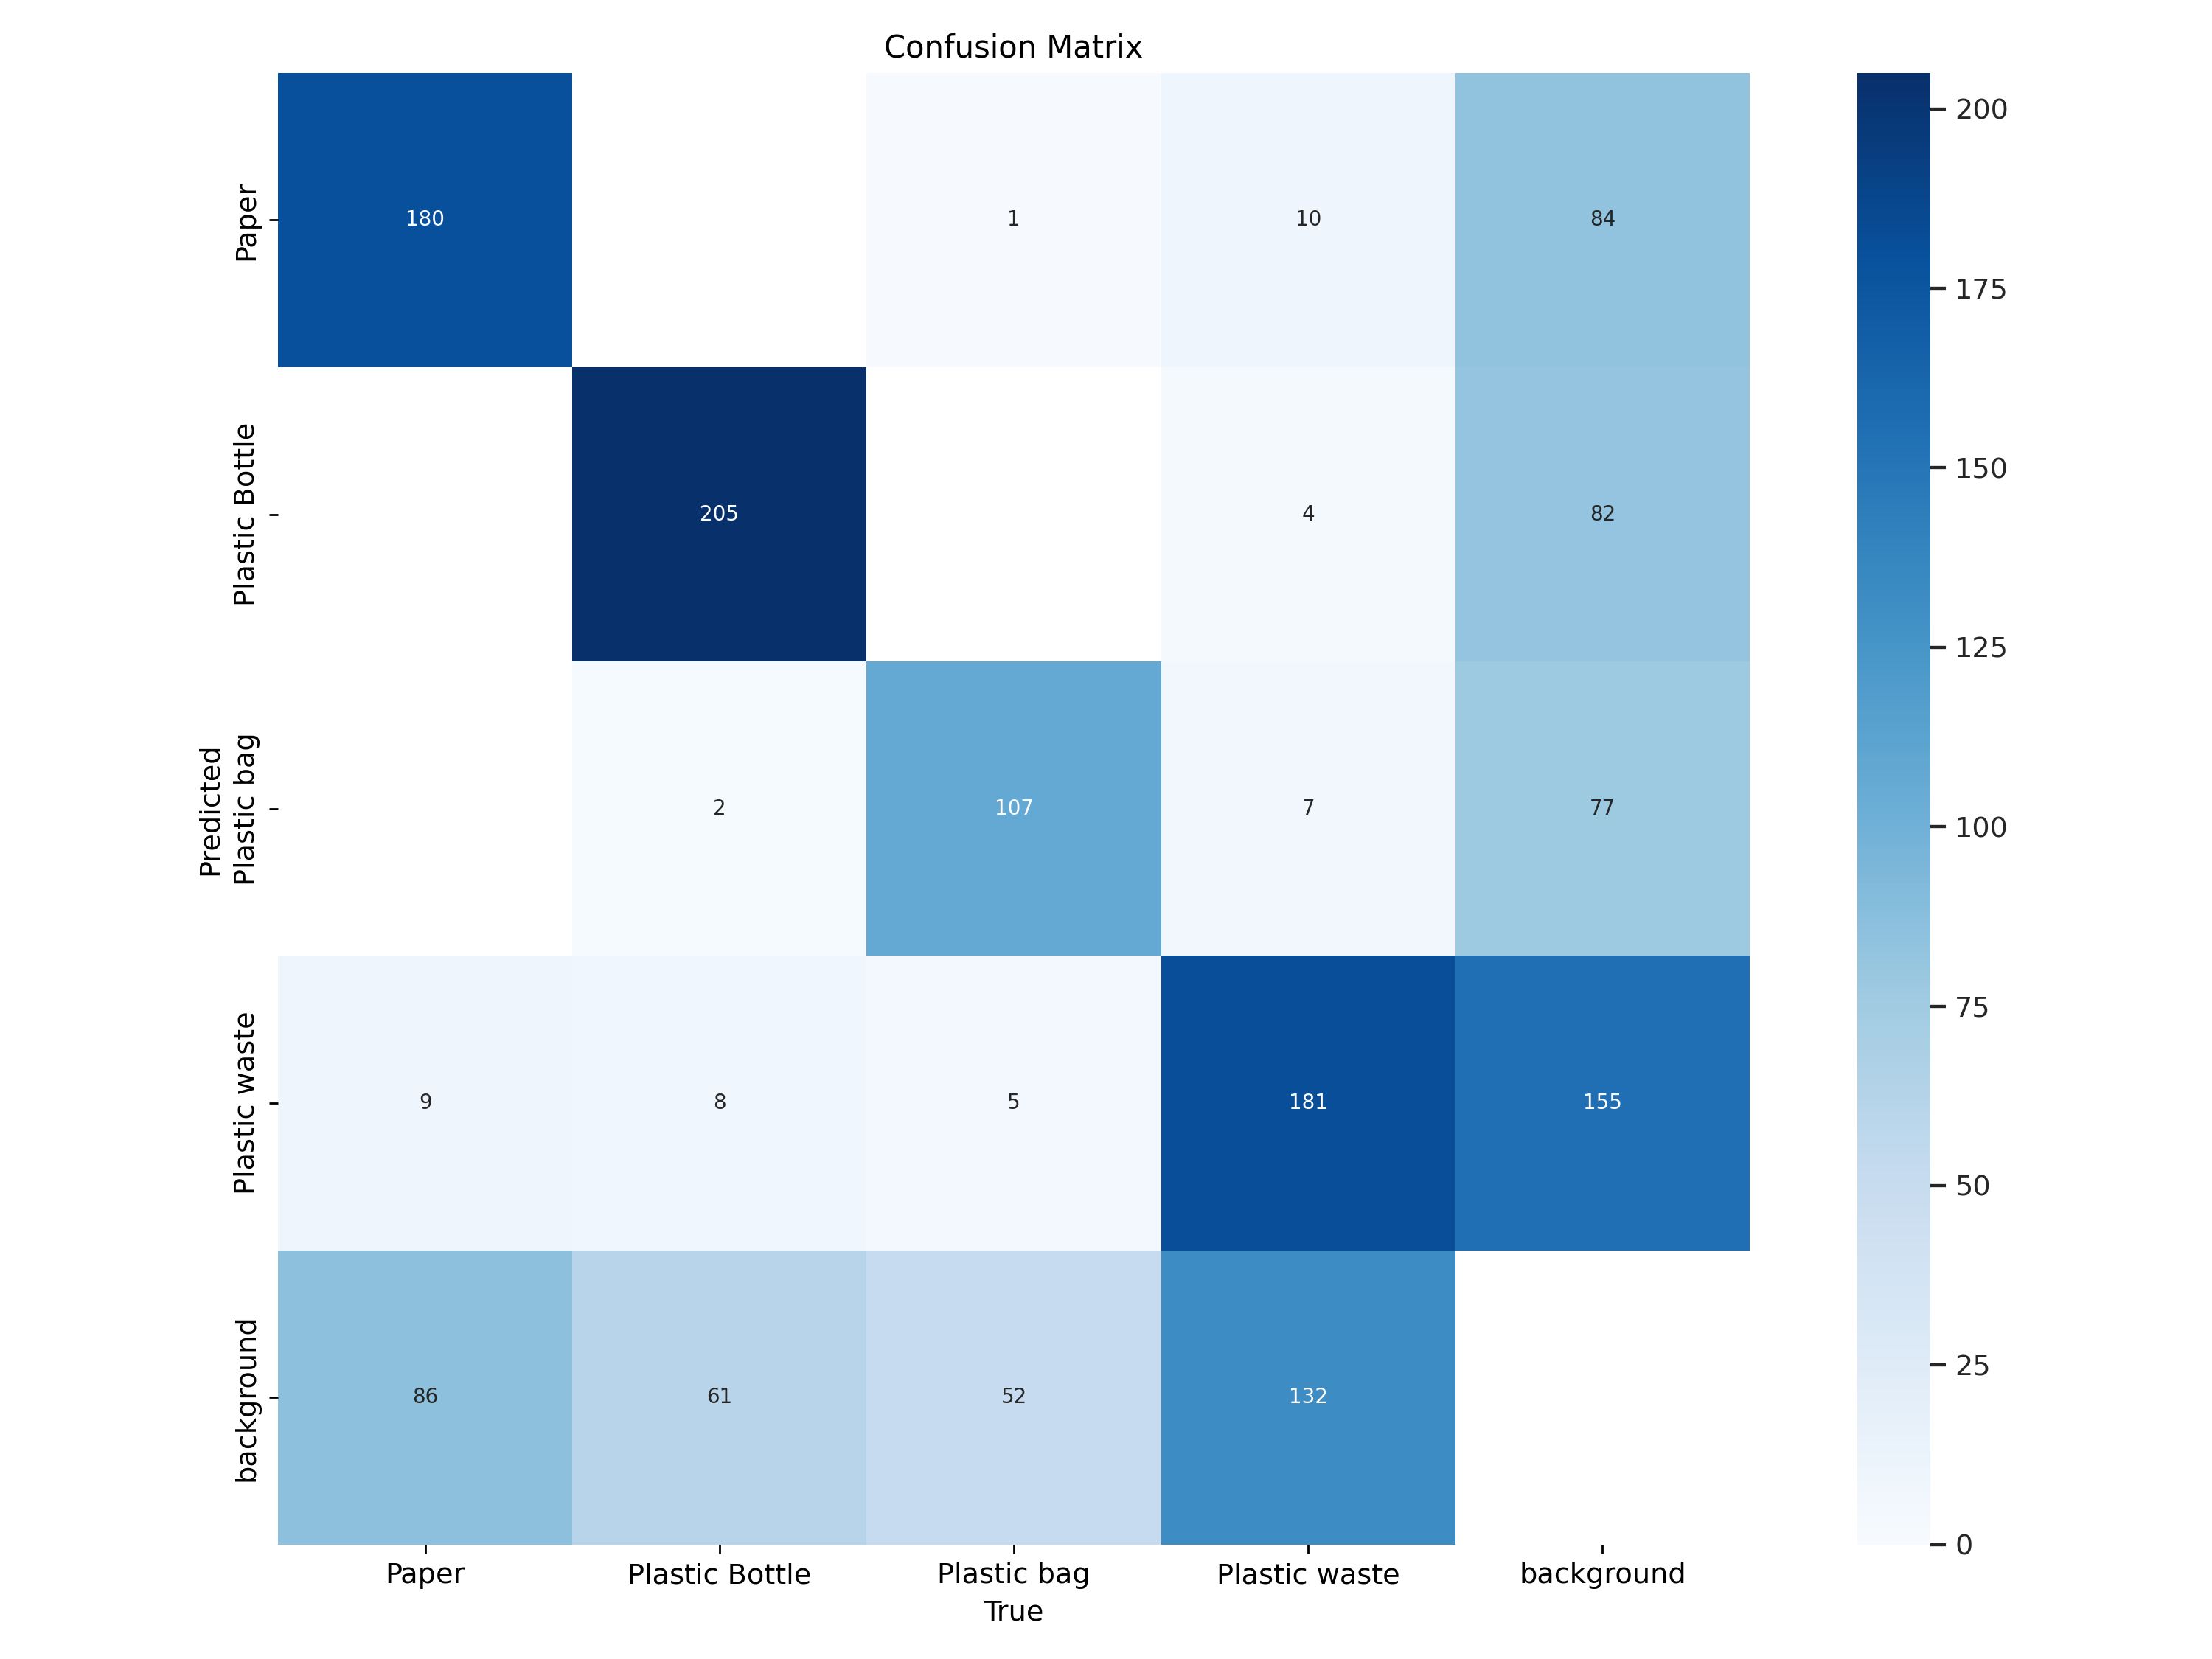

In [58]:
%cd {HOME}
Image.open(f'{HOME}/runs/detect/train/confusion_matrix.png')

/kaggle/working


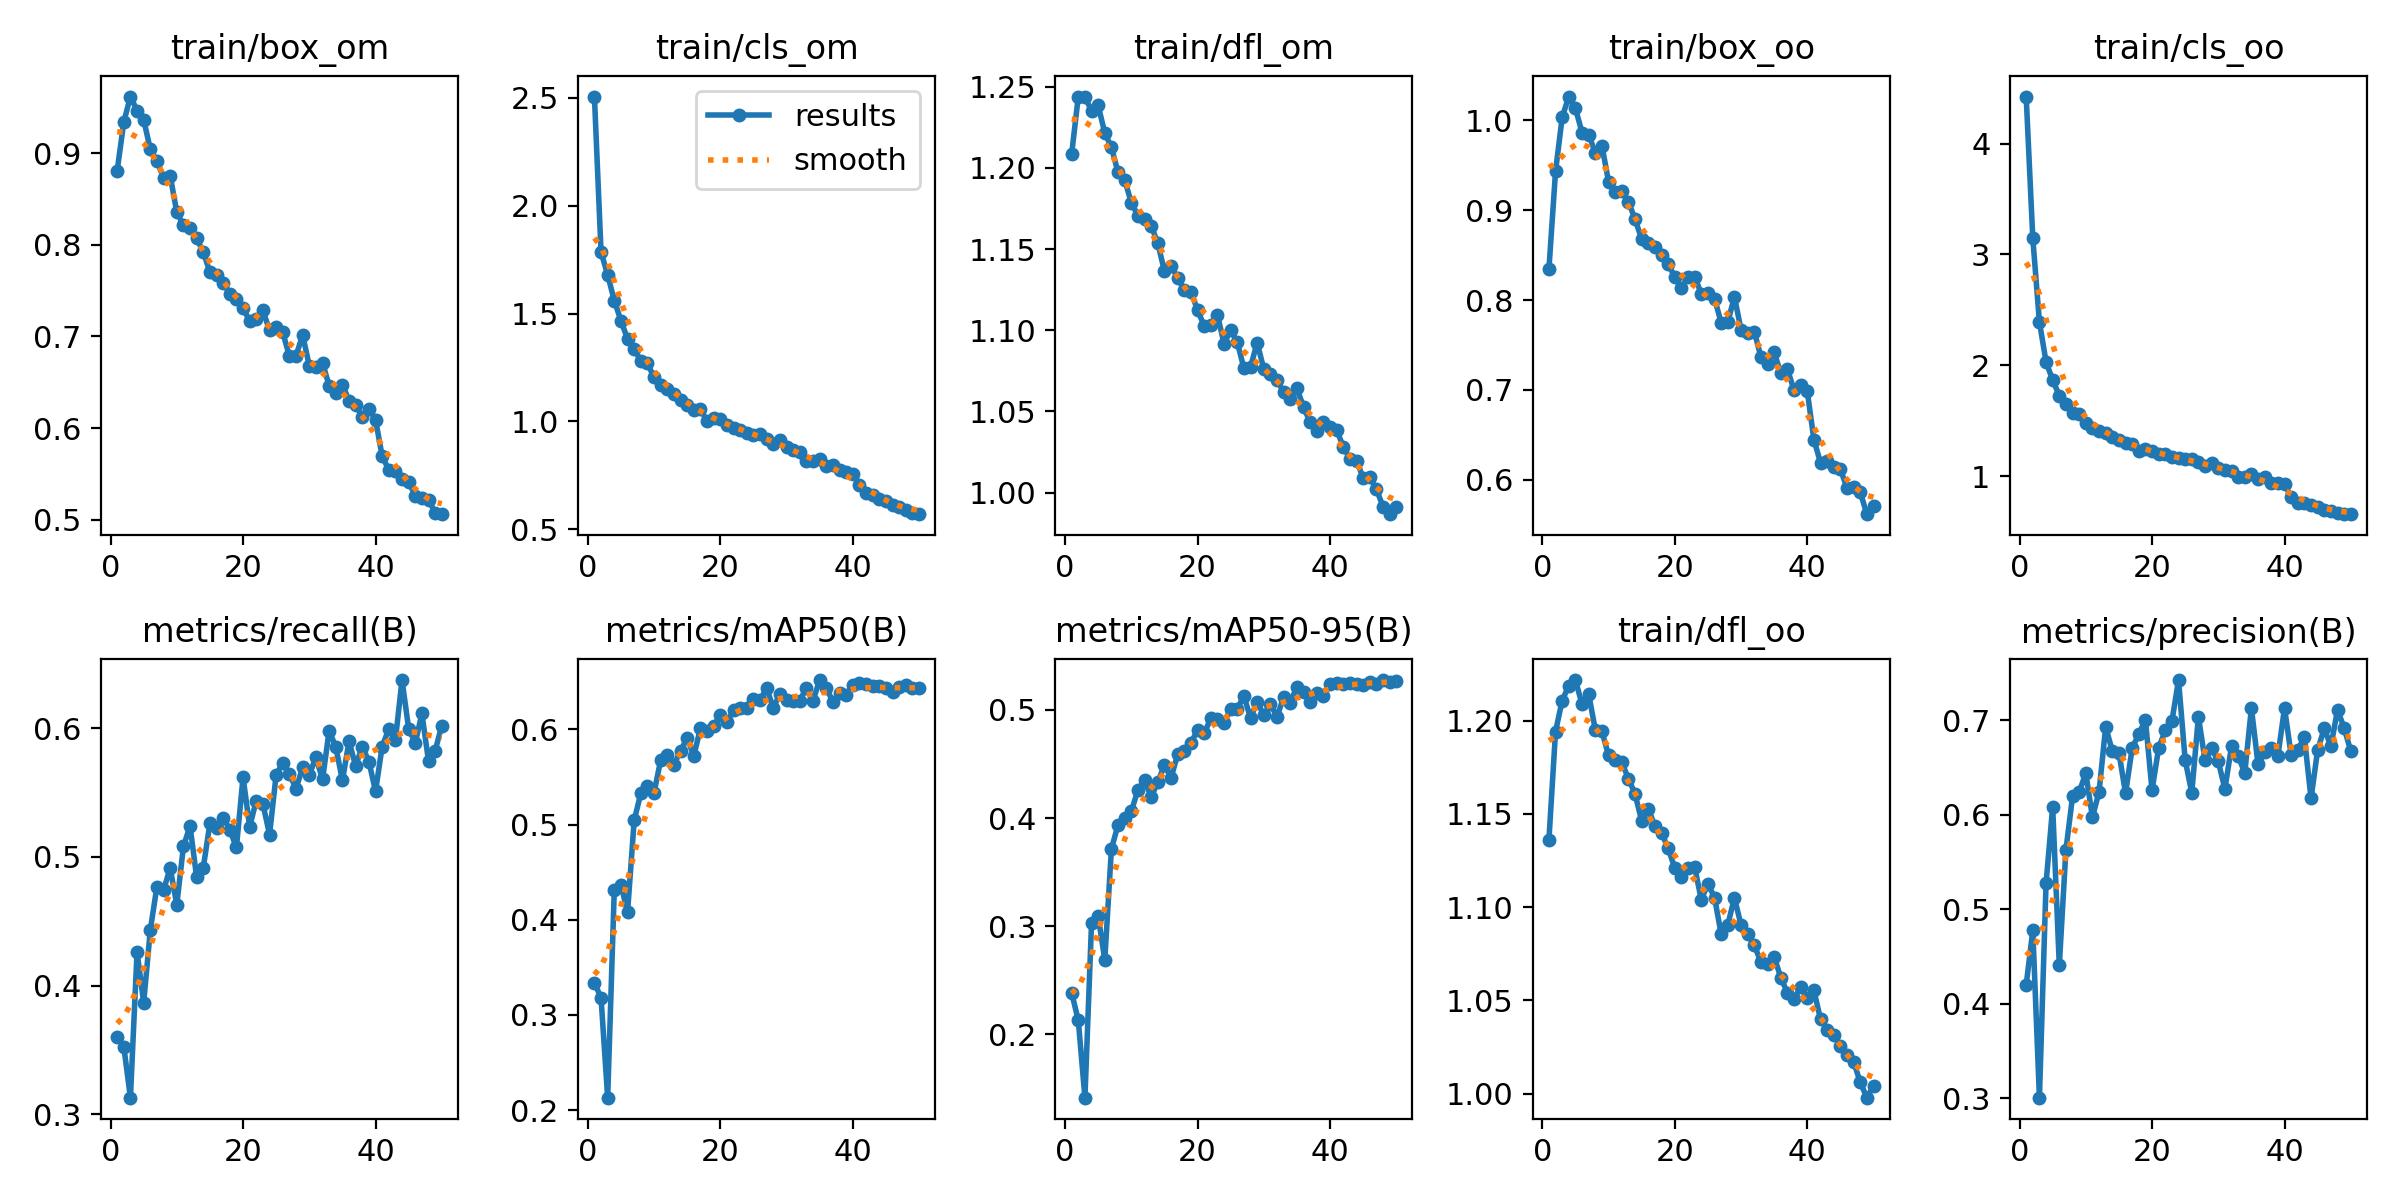

In [59]:
%cd {HOME}
Image.open(f'{HOME}/runs/detect/train/results.png')

In [62]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/kaggle/working
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2695976 parameters, 0 gradients, 8.2 GFLOPs
val: Scanning /kaggle/working/datasets/Waste-Detections-6/valid/labels.cache... 
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        427       1050       0.71      0.573      0.646      0.528
                 Paper        427        275      0.776      0.567      0.686      0.578
        Plastic Bottle        427        276      0.811      0.707      0.783      0.672
           Plastic bag        427        165      0.665      0.588      0.624      0.498
         Plastic waste        427        334      0.588      0.432      0.492      0.362
Speed: 0.9ms preprocess, 6.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [63]:
! zip -r yolov10n_recyclablewaste.zip {HOME}/runs/

  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/val/ (stored 0%)
  adding: kaggle/working/runs/detect/val/PR_curve.png (deflated 10%)
  adding: kaggle/working/runs/detect/val/val_batch0_pred.jpg (deflated 3%)
  adding: kaggle/working/runs/detect/val/confusion_matrix.png (deflated 26%)
  adding: kaggle/working/runs/detect/val/val_batch0_labels.jpg (deflated 3%)
  adding: kaggle/working/runs/detect/val/F1_curve.png (deflated 10%)
  adding: kaggle/working/runs/detect/val/val_batch2_labels.jpg (deflated 4%)
  adding: kaggle/working/runs/detect/val/R_curve.png (deflated 10%)
  adding: kaggle/working/runs/detect/val/confusion_matrix_normalized.png (deflated 23%)
  adding: kaggle/working/runs/detect/val/val_batch2_pred.jpg (deflated 4%)
  adding: kaggle/working/runs/detect/val/P_curve.png (deflated 8%)
  adding: kaggle/working/runs/detect/val/val_batch1_pred.jpg (deflated 4%)
  adding: kaggle/working/runs/detect

## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [64]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/kaggle/working
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2695976 parameters, 0 gradients, 8.2 GFLOPs

image 1/283 /kaggle/working/datasets/Waste-Detections-6/test/images/20250303_141402_jpg.rf.eca6609b65e2645932230f9186be83f4.jpg: 640x640 6 Plastic Bottles, 10.1ms
image 2/283 /kaggle/working/datasets/Waste-Detections-6/test/images/20250303_141446_jpg.rf.fff8ddd58bfa68db3ad17b97c8d21949.jpg: 640x640 6 Plastic wastes, 9.9ms
image 3/283 /kaggle/working/datasets/Waste-Detections-6/test/images/20250303_141649_jpg.rf.30d1a279399f53b8d35f8567c01d9874.jpg: 640x640 6 Plastic wastes, 10.1ms
image 4/283 /kaggle/working/datasets/Waste-Detections-6/test/images/20250303_141652_jpg.rf.f9c3ff2eb28a69c88222dc0a89e4a0ac.jpg: 640x640 5 Plastic wastes, 8.6ms
image 5/283 /kaggle/working/datasets/Waste-Detections-6/test/images/20250303_141654_jpg.rf.0a76417ecdcfc7ae4fffb7fa0cdb3d21.jpg: 640x640 6 Plastic wastes, 8.6ms
image 6/283 

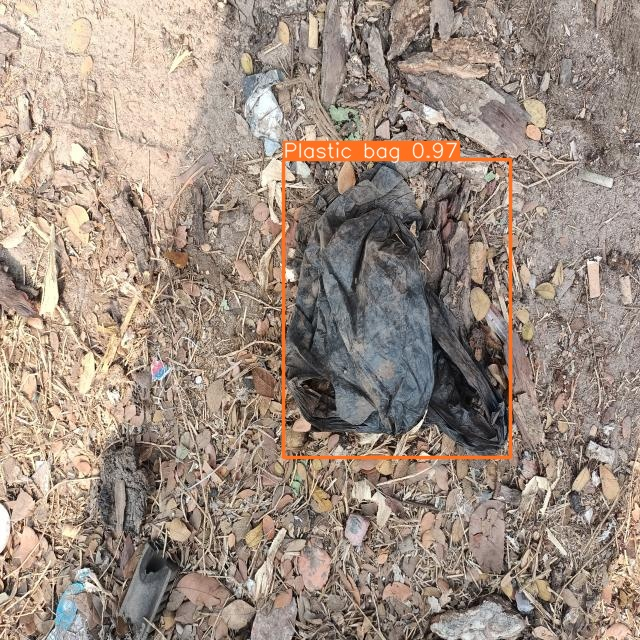

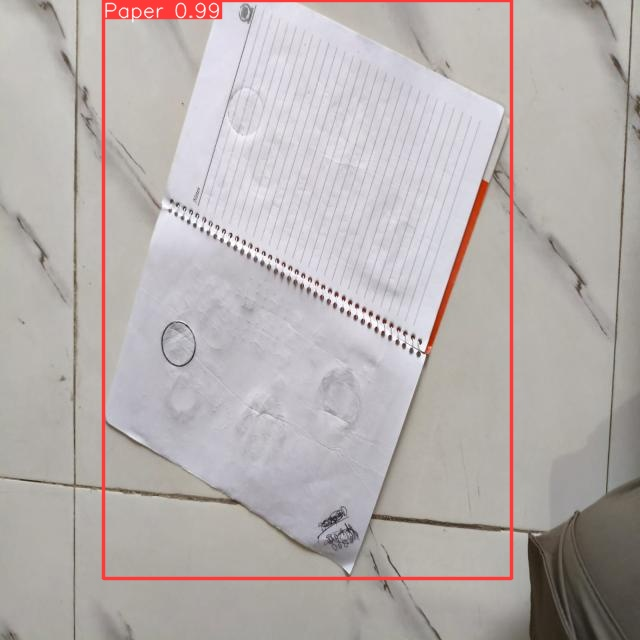

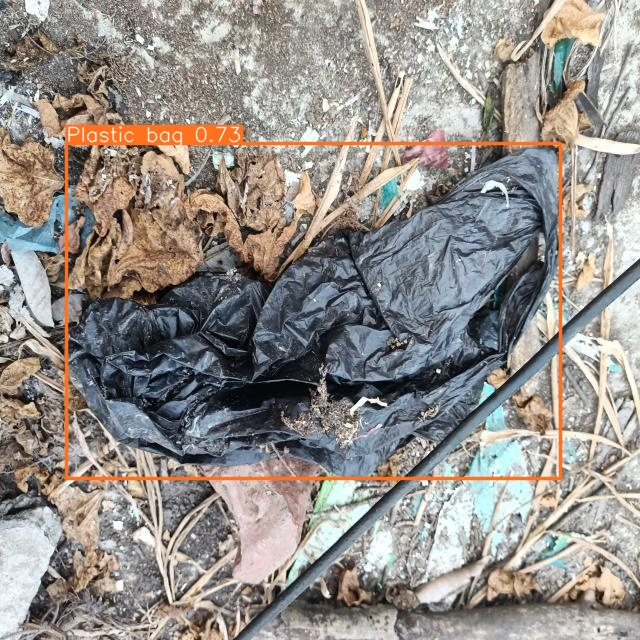

In [65]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict2/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [66]:
# from ultralytics import YOLOv10

# model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

# dataset = sv.DetectionDataset.from_yolo(
#     images_directory_path=f"{dataset.location}/valid/images",
#     annotations_directory_path=f"{dataset.location}/valid/labels",
#     data_yaml_path=f"{dataset.location}/data.yaml"
# )

# bounding_box_annotator = sv.BoundingBoxAnnotator()
# label_annotator = sv.LabelAnnotator()

**NOTE:** Let's randomly select an image from our validation set and visualize the results.

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)